# Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# add the repo where utilities is stored
import sys
sys.path.append('/Users/avicenne/Documents/python/Github/')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
### arbre de décision
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.ensemble import RandomForestClassifier
import utilities
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Dataset importation : Take a look at the data

In [3]:
## datasets importation

train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

print(len(train))
train.head(5)

891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: title={'center': 'Bar graph with max value'}, xlabel='Missing values', ylabel='Label columns'>

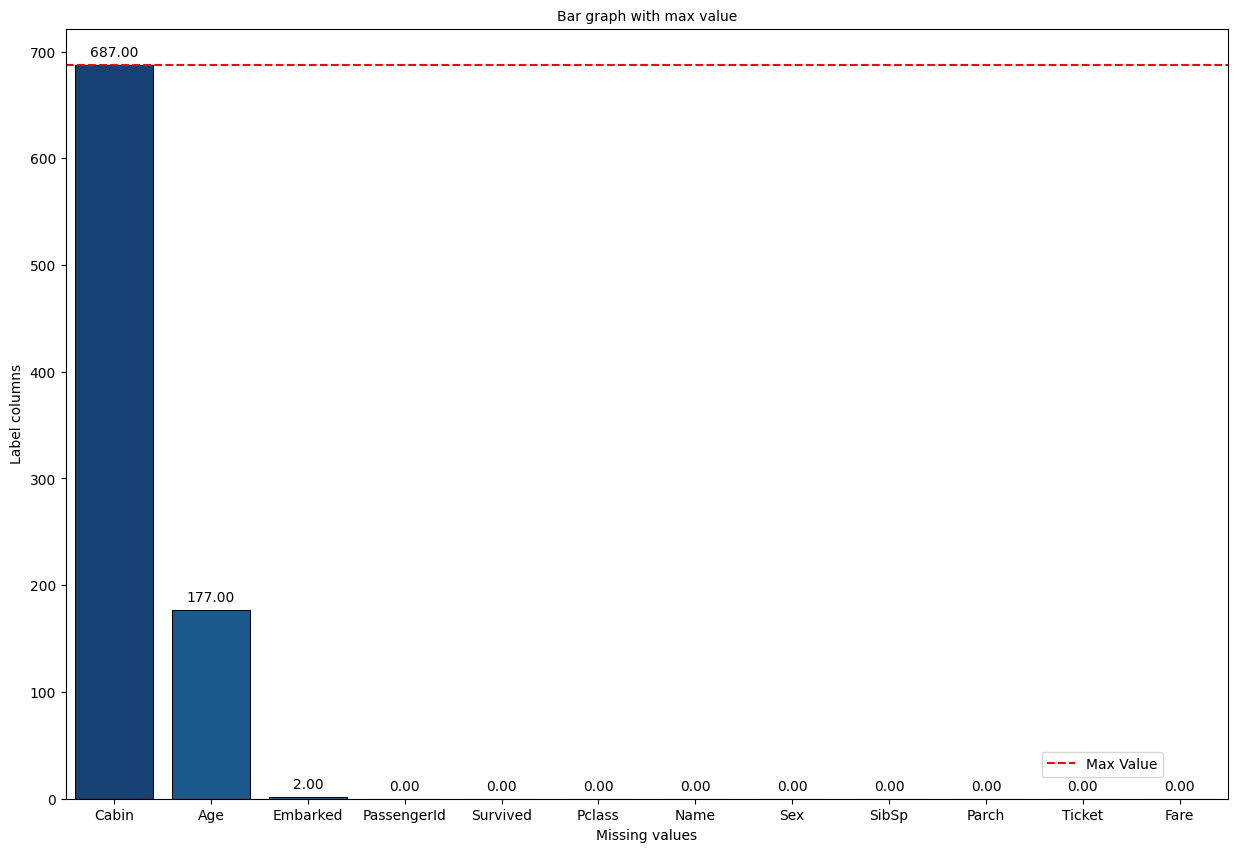

In [4]:
fig, ax = plt.subplots(figsize=(15, 10))
utilities.plot_bar_graph(train.isna().sum().tolist(),
               train.isna().columns.tolist(),
               'Missing values', 'Label columns', color = plt.cm.GnBu_r, ax=ax)

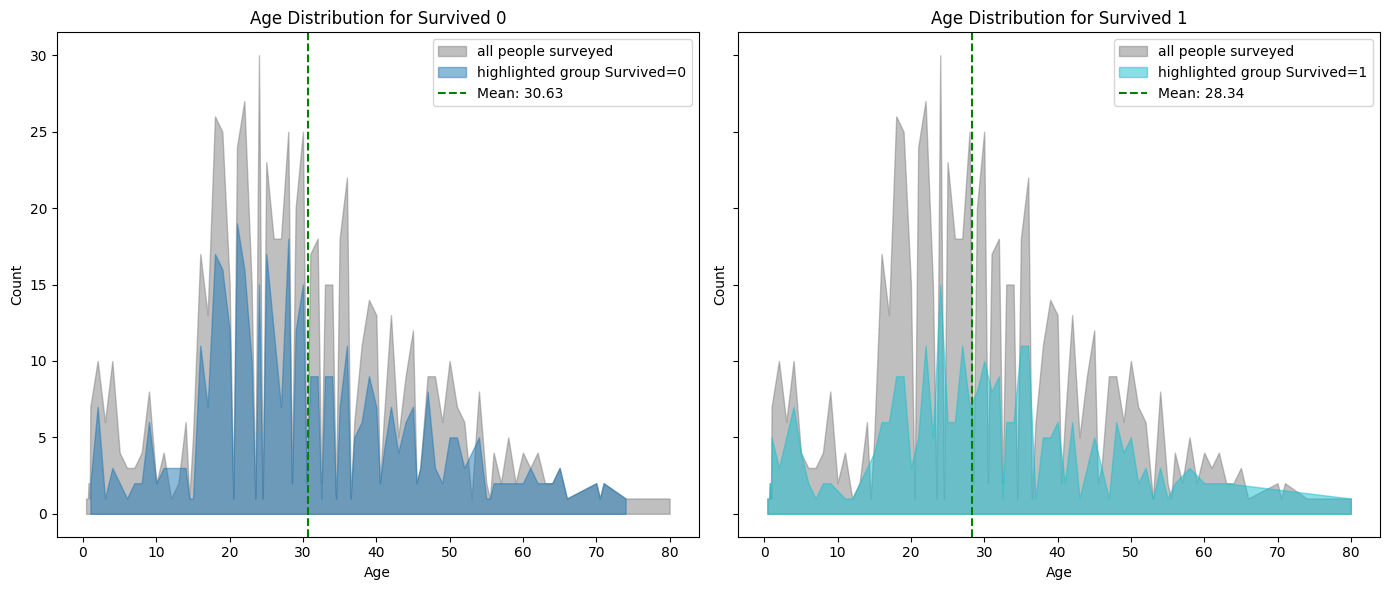

In [5]:
utilities.display_classes_repartition(train, 'Age', 'Survived')

<Axes: title={'center': 'Density of Fare for Survived = 1'}, xlabel='Fare', ylabel='Density'>

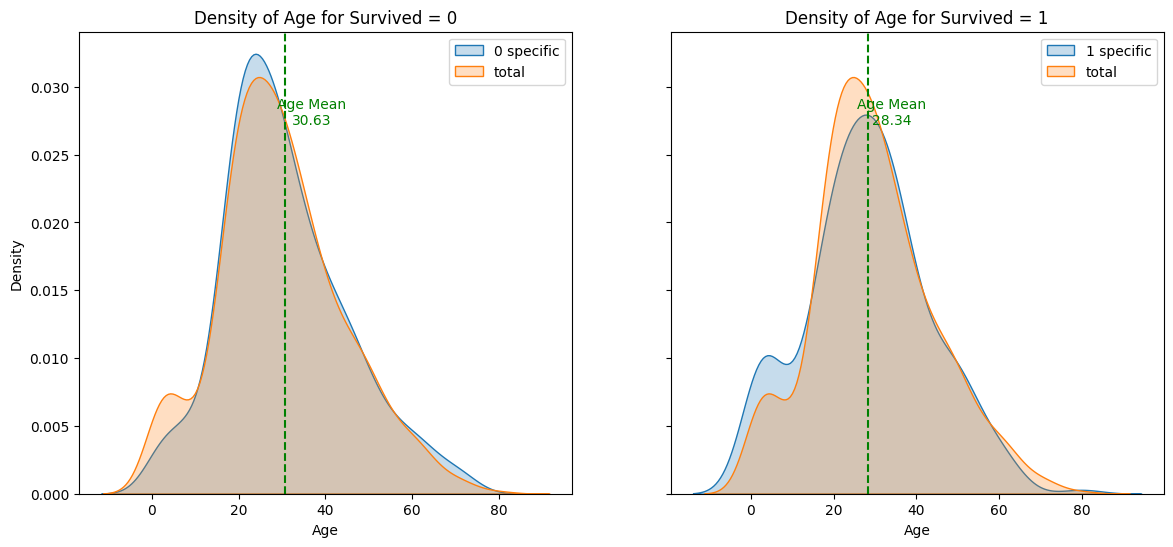

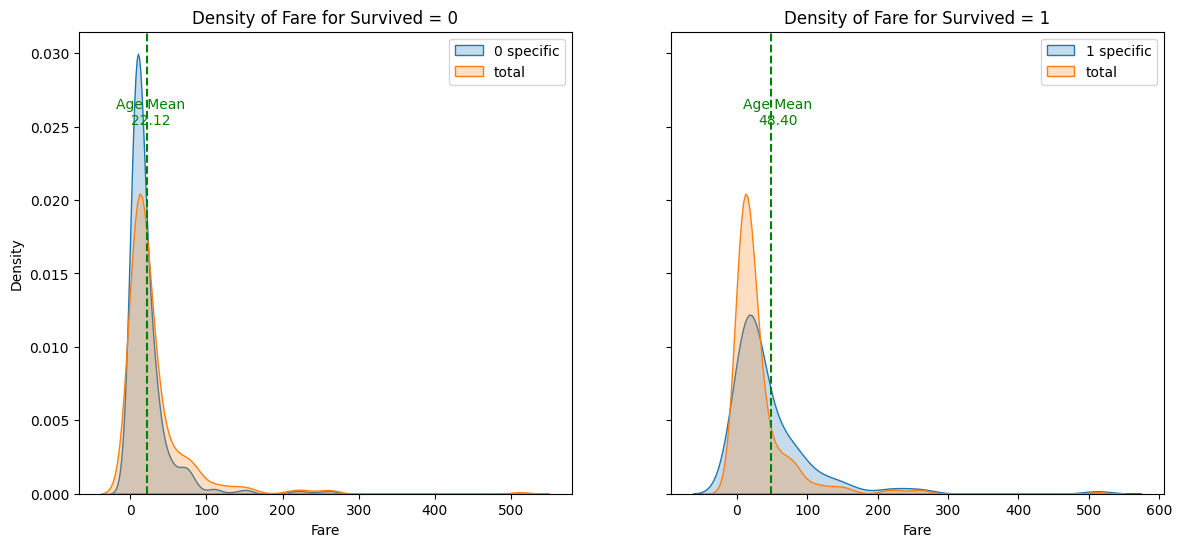

In [6]:
utilities.display_density_comparison(train, 'Age', 'Survived')
utilities.display_density_comparison(train, 'Fare', 'Survived')

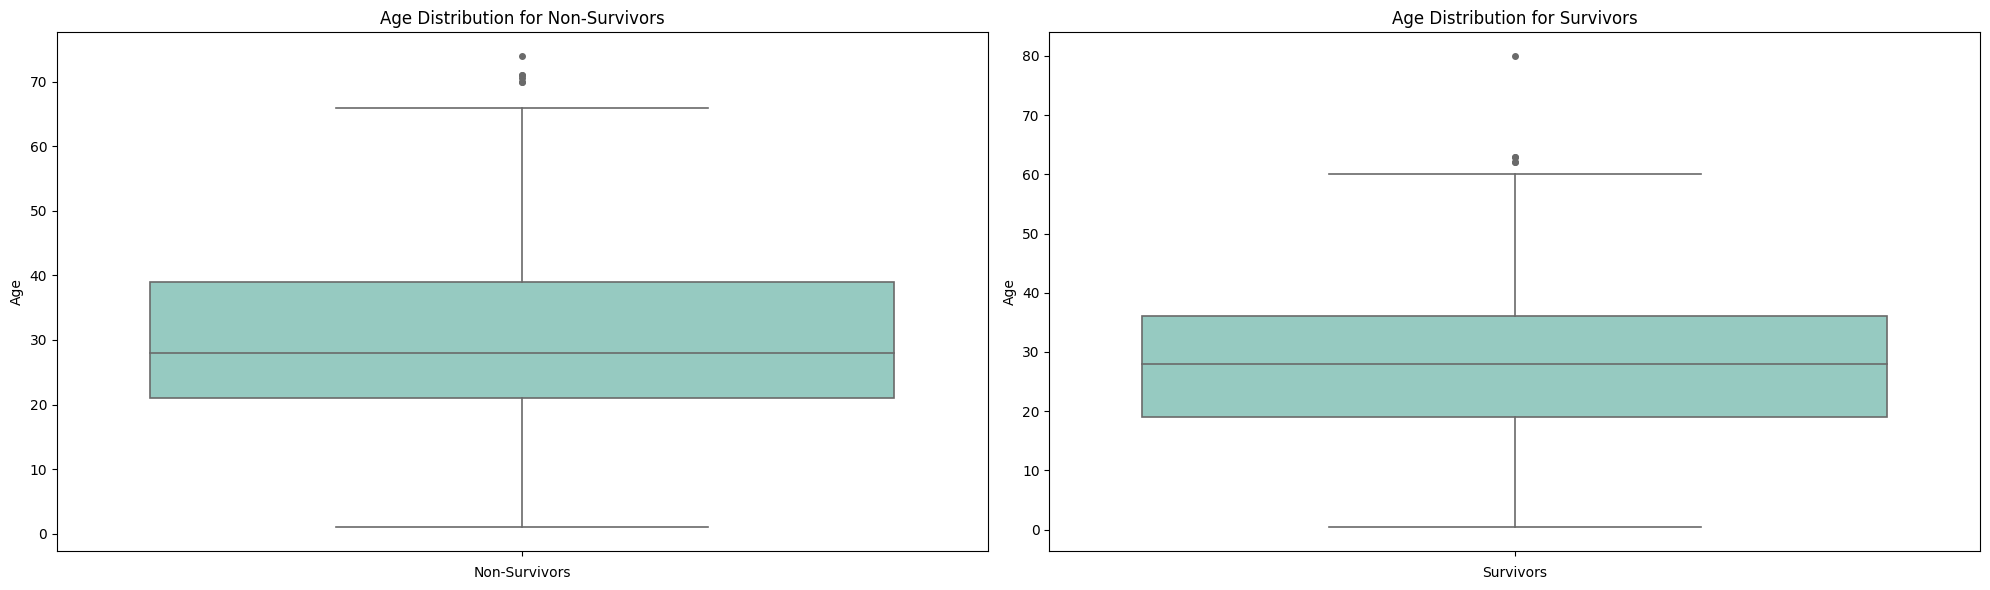

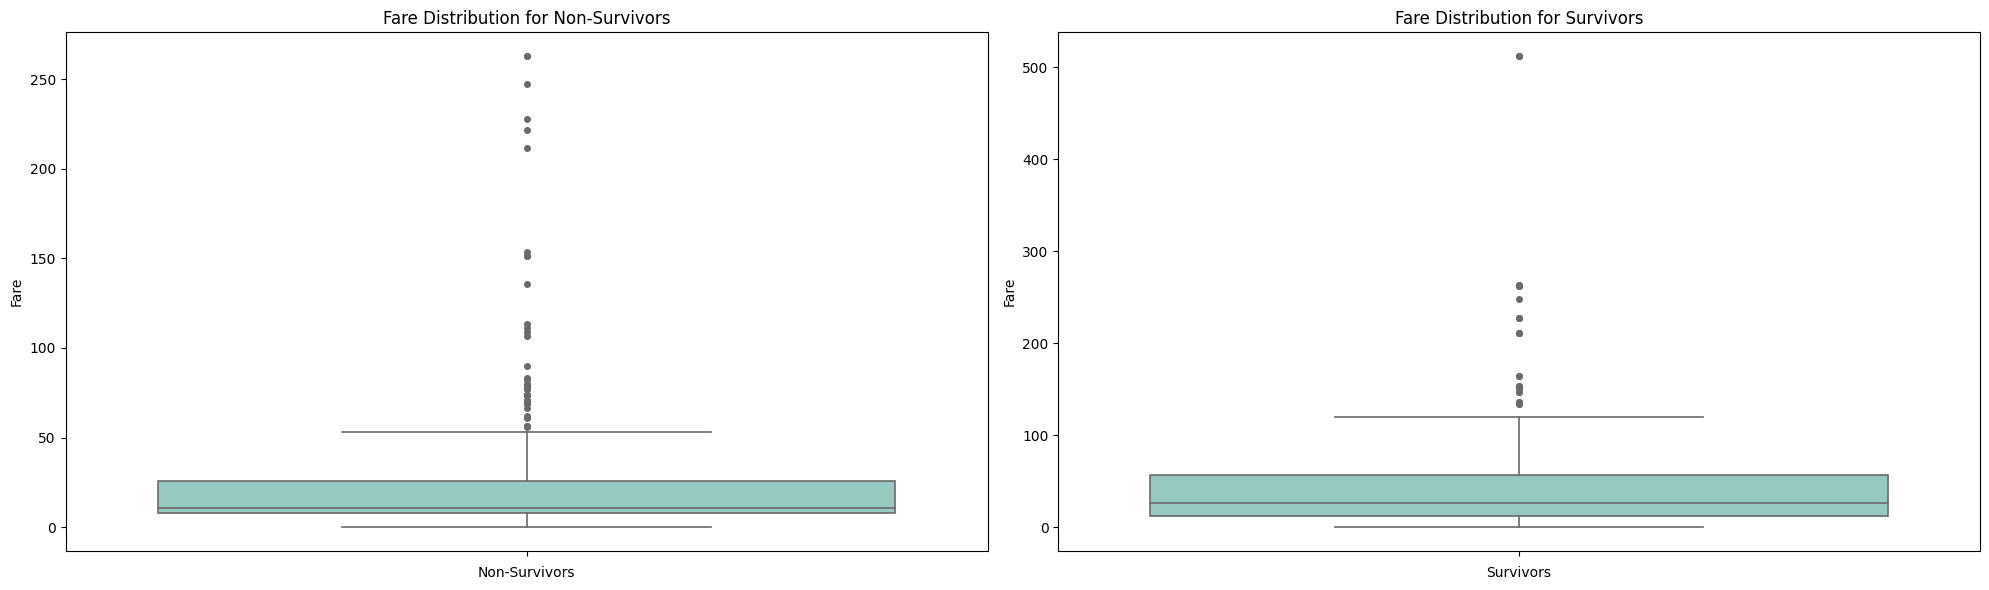

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sb.boxplot(data=train[train['Survived'] == 0], y='Age',
           palette='Set3', linewidth=1.2, fliersize=2,
           flierprops=dict(marker='o', markersize=4), ax=axes[0])
axes[0].set_title('Age Distribution for Non-Survivors')
axes[0].set_ylabel('Age')
axes[0].set_xlabel('Non-Survivors')

sb.boxplot(data=train[train['Survived'] == 1], y='Age',
           palette='Set3', linewidth=1.2, fliersize=2,
           flierprops=dict(marker='o', markersize=4), ax=axes[1])
axes[1].set_title('Age Distribution for Survivors')
axes[1].set_ylabel('Age')
axes[1].set_xlabel('Survivors')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sb.boxplot(data=train[train['Survived'] == 0], y='Fare',
           palette='Set3', linewidth=1.2, fliersize=2,
           flierprops=dict(marker='o', markersize=4), ax=axes[0])
axes[0].set_title('Fare Distribution for Non-Survivors')
axes[0].set_ylabel('Fare')
axes[0].set_xlabel('Non-Survivors')

sb.boxplot(data=train[train['Survived'] == 1], y='Fare',
           palette='Set3', linewidth=1.2, fliersize=2,
           flierprops=dict(marker='o', markersize=4), ax=axes[1])
axes[1].set_title('Fare Distribution for Survivors')
axes[1].set_ylabel('Fare')
axes[1].set_xlabel('Survivors')

plt.tight_layout()
plt.show()

# Handleling missing values : Age, Cabin, Embarked

In [8]:
## avec creat_bin on choisit ou non de créer des classes pour segmenter certaines données

def clean_data(data, creat_bin):
    """The goal of this function is to clean the dataset : fillna...

    Args:
        data (pd.DataFrame): the dataset we want to process
        creat_bin (Boolean): if or not we want to create bin for Age and Fare

    Returns:
        data : the cleaned dataset
    """
 
    # we replace NaN by mean and most common value
    data.Age = data.Age.fillna(data.Age.mean())   
    data.Fare = data.Fare.fillna(data.Fare.mean())
    data.Embarked = data.Embarked.fillna('S')  
        
    # we regroupe the first char for Cabin and Ticket. For Cabin the "N" char represent NaN value
    # there is so many NaN values in Cabin that we keep it as a label
    data['Cabin_Prefix'] = data['Cabin'].apply(lambda x: str(x)[0])  # 0 for the first char
    data['Ticket_Prefix'] = data['Ticket'].apply(lambda x: x[:1])  
    
    # We extract the title of a person and we keep the most significant ['Mr', 'Miss', 'Mrs', 'Master']
    data['Title'] = data['Name'].apply(lambda txt : txt.split()[1].replace('.', ''))
    data['Title'] = data['Title'].apply(lambda txt: txt if txt in ['Mr', 'Miss', 'Mrs', 'Master'] else 'unk')
        
    # if we want to create categories for Age and Fare
    if creat_bin:
        
        data['Age_Range'] = pd.cut(data['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])
        data['Fare_Range'] = pd.cut(data['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])
        
        data = pd.get_dummies(data, columns = ["Sex","Title","Age_Range","Embarked", "Fare_Range"],
                             prefix=["Sex","Title","Age_type","Em_type", "Fare"], dummy_na=False)

        data = data.drop(['PassengerId', 'Name', 'Age', 'Ticket', 'Fare', 'Cabin', "Ticket_Prefix", "Cabin_Prefix"], axis = 1)
      
    else:  
        data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
        
    return data

train = pd.read_csv('/kaggle/input/titanic-dataset/train.csv')
test = pd.read_csv('/kaggle/input/titanic-dataset/test.csv')
# we make sure that there is no Nan values
test = clean_data(test, creat_bin = False)
train = clean_data(train, creat_bin = False)
print(train.isna().any())

Survived         False
Pclass           False
Sex              False
Age              False
SibSp            False
Parch            False
Fare             False
Embarked         False
Cabin_Prefix     False
Ticket_Prefix    False
Title            False
dtype: bool


<Axes: title={'center': 'Density of Fare for Survived = 1'}, xlabel='Fare', ylabel='Density'>

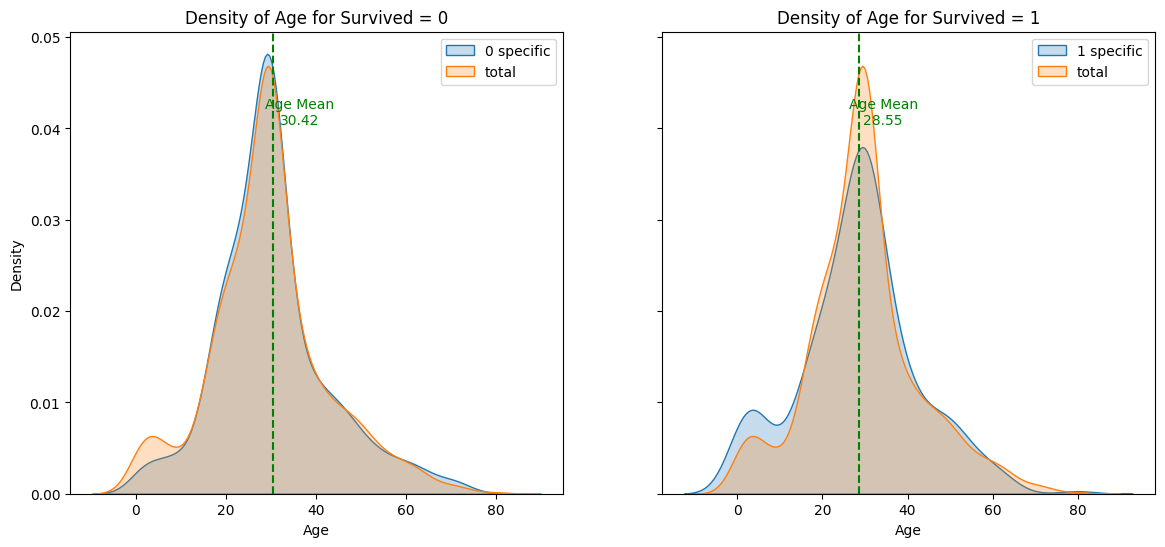

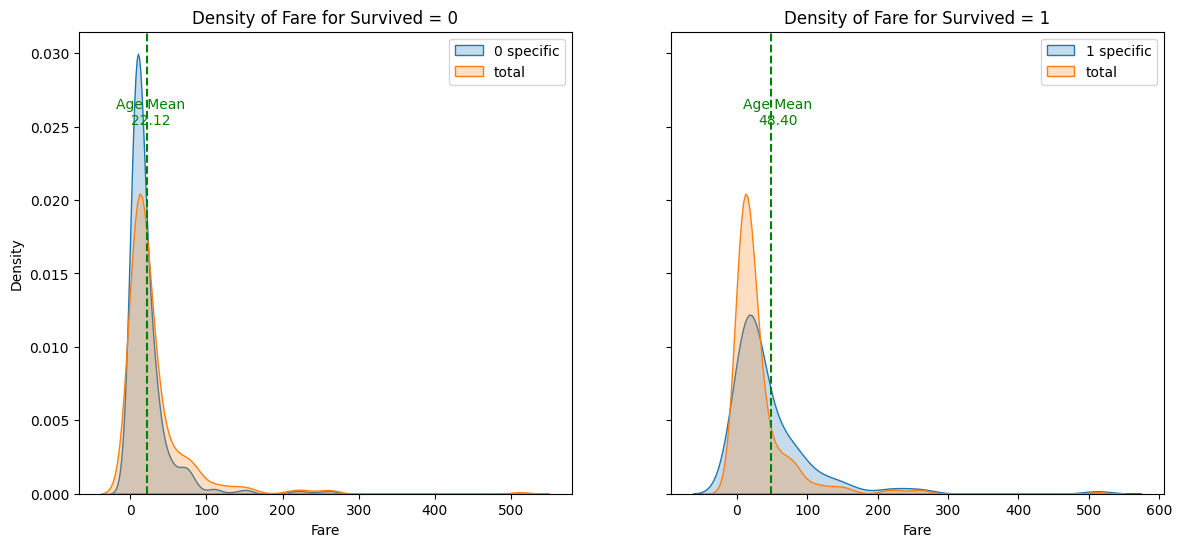

In [9]:
# some Data Visualisation

utilities.display_density_comparison(train, 'Age', 'Survived')
utilities.display_density_comparison(train, 'Fare', 'Survived')


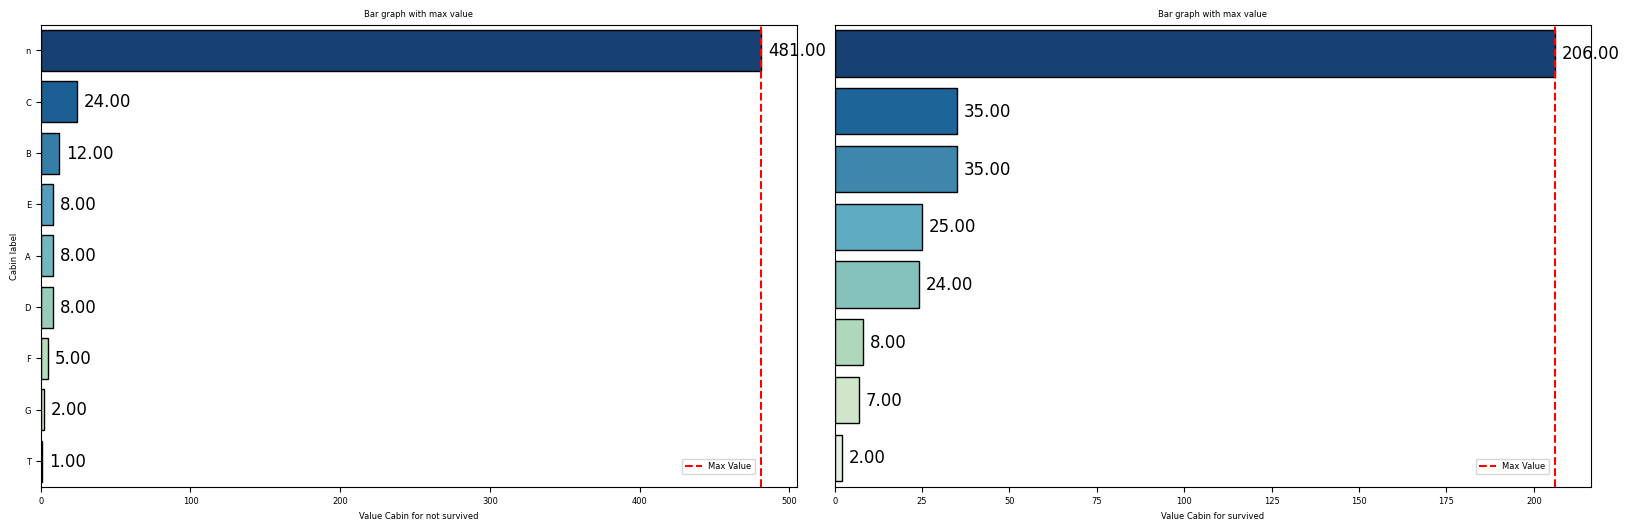

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax0 = utilities.plot_barh_graph(train[train['Survived'] == 0].Cabin_Prefix.value_counts().tolist(),
               train[train['Survived'] == 0].Cabin_Prefix.value_counts().index.tolist(),
               'Value Cabin for not survived', 'Cabin label',
                color = plt.cm.GnBu_r, ax = axes[0])

ax1 = utilities.plot_barh_graph(train[train['Survived'] == 1].Cabin_Prefix.value_counts().tolist(),
               train[train['Survived'] == 1].Cabin_Prefix.value_counts().index.tolist(),
               'Value Cabin for survived', 'Cabin label', 
                color = plt.cm.GnBu_r, ax = axes[1])

ax1.set_ylabel('')
plt.setp(ax1.get_yticklabels(), visible = False)
plt.setp(ax1.get_yticklines(), visible = False)
plt.subplots_adjust(wspace=0.05)
plt.show()

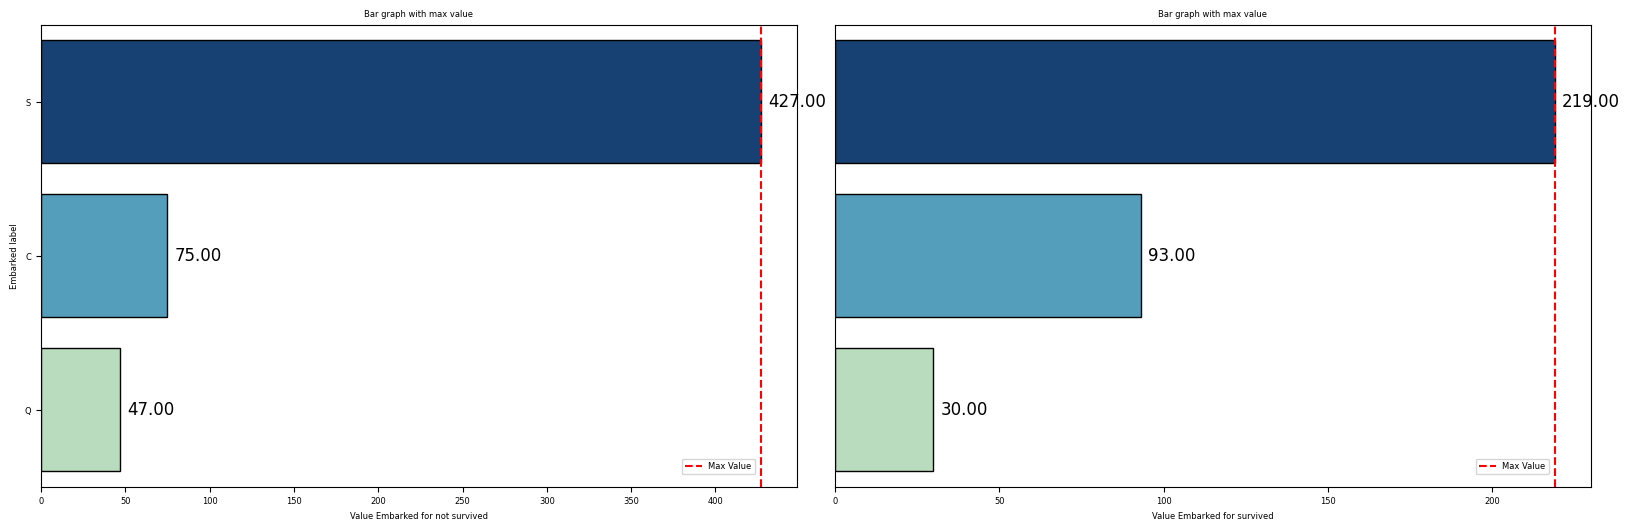

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax0 = utilities.plot_barh_graph(train[train['Survived'] == 0].Embarked.value_counts().tolist(),
               train[train['Survived'] == 0].Embarked.value_counts().index.tolist(),
               'Value Embarked for not survived', 'Embarked label', 
                color = plt.cm.GnBu_r, ax = axes[0])

ax1 = utilities.plot_barh_graph(train[train['Survived'] == 1].Embarked.value_counts().tolist(),
               train[train['Survived'] == 1].Embarked.value_counts().index.tolist(),
               'Value Embarked for survived', 'Embarked label', 
                color = plt.cm.GnBu_r, ax = axes[1])

ax1.set_ylabel('')
plt.setp(ax1.get_yticklabels(), visible = False)
plt.setp(ax1.get_yticklines(), visible = False)
plt.subplots_adjust(wspace=0.05)
plt.show()

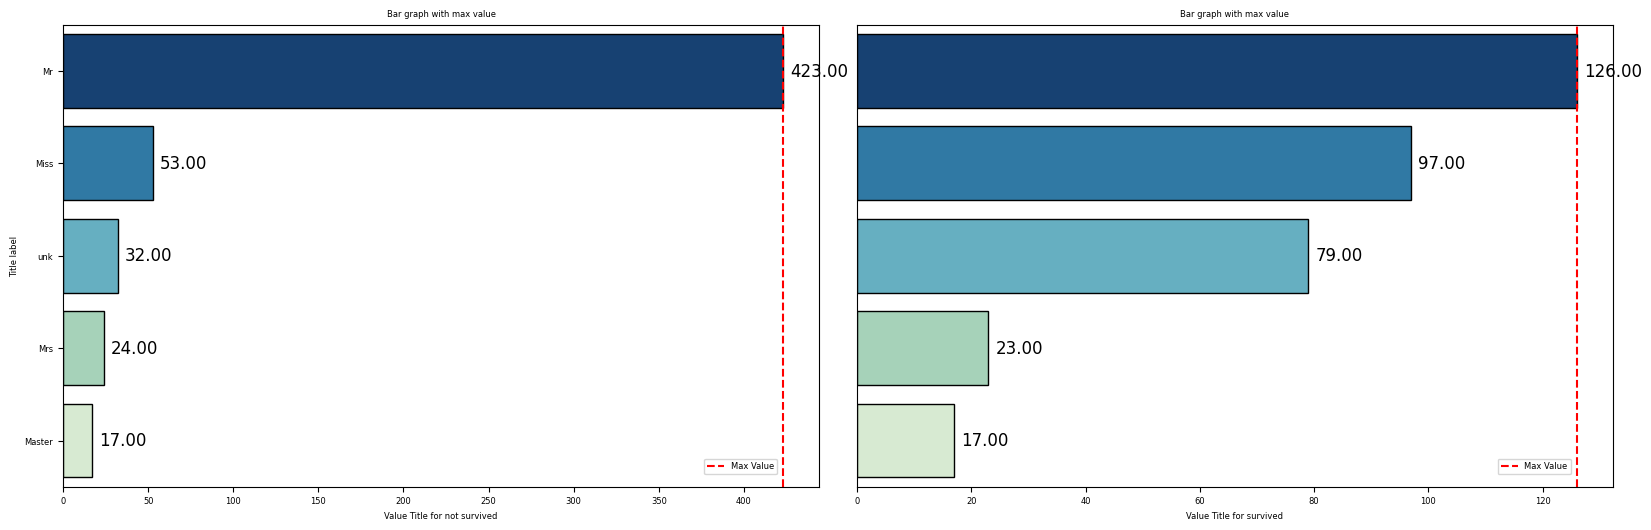

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax0 = utilities.plot_barh_graph(train[train['Survived'] == 0].Title.value_counts().tolist(),
               train[train['Survived'] == 0].Title.value_counts().index.tolist(),
               'Value Title for not survived', 'Title label', 
                color = plt.cm.GnBu_r, ax = axes[0])

ax1 = utilities.plot_barh_graph(train[train['Survived'] == 1].Title.value_counts().tolist(),
               train[train['Survived'] == 1].Title.value_counts().index.tolist(),
               'Value Title for survived', 'Title label', 
                color = plt.cm.GnBu_r, ax = axes[1])

ax1.set_ylabel('')
plt.setp(ax1.get_yticklabels(), visible = False)
plt.setp(ax1.get_yticklines(), visible = False)
plt.subplots_adjust(wspace=0.05)
plt.show()

# We labelize data

In [13]:
def labelize_data(train, test, display_heat_map):
    
    # we save the lable we will predict 
    y_train = train.Survived
    
    # label we need to labelize
    need_labelize = [label for label in train.columns if train[label].dtype =='object']
    encode = LabelEncoder()
        
    for lab in need_labelize:
        print("need labelize :", lab)
        encode.fit(train[lab])
        train[lab] = encode.transform(train[lab])
        test[lab] = encode.transform(test[lab])
    
    # correlation
    correlation = train.corr()
    sb.heatmap(correlation, cmap = 'magma')
    if display_heat_map:
        plt.show()
    
    return train, test, y_train

Finally we can process the whole data

need labelize : Sex
need labelize : Embarked
need labelize : Cabin_Prefix
need labelize : Ticket_Prefix
need labelize : Title


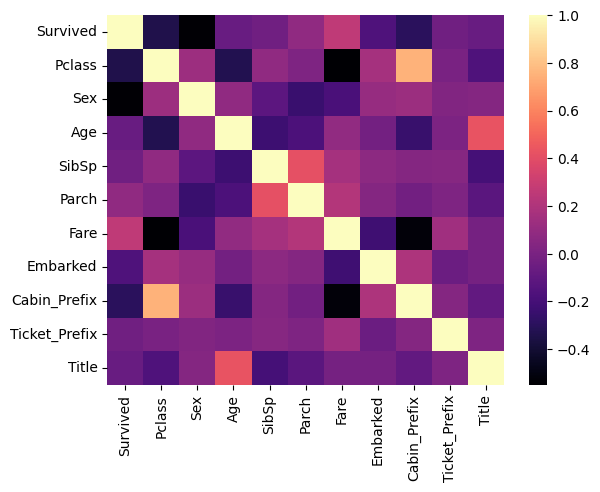

len x_train:  (623, 10)
len x_val:  (268, 10)
len label_train:  (623,)
len label_val:  (268,)


In [14]:
train = pd.read_csv('/kaggle/input/titanic-dataset/train.csv')
test = pd.read_csv('/kaggle/input/titanic-dataset/test.csv')

# We save the ID
Id = test.PassengerId

# we clean
train = clean_data(train, creat_bin= False)
test = clean_data(test, creat_bin= False)

# we labelize
train, test, y_train= labelize_data(train, test, display_heat_map = True)

train = train.drop(['Survived'], axis = 1)

# we split
x_train, x_val, y_train, y_val = train_test_split(train, y_train, test_size = 0.3, random_state = 42)

print("len x_train: ",x_train.shape)
print("len x_val: ", x_val.shape)
print("len label_train: ",y_train.shape)
print("len label_val: ", y_val.shape)
    

# Find optimal hyperparams

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


def get_hyppars_(model, params, n_iter, cv, scoring, n_jobs,
                random_state, x_train, y_train, x_val, y_val):

    # Initialisation RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, 
                                       n_iter=n_iter, cv=cv,
                                       scoring=scoring, n_jobs=n_jobs, random_state=42)

    # Train
    random_search.fit(x_train, y_train)

    # Print
    print("Best parameters found using random_search: ", random_search.best_params_)
    print("Best accuracy score found during search using random_search: ", random_search.best_score_)

In [16]:
from catboost import CatBoostClassifier

models = [CatBoostClassifier(verbose=0), LogisticRegression()]
params = [{
            'iterations': randint(80, 1000),
            'learning_rate': uniform(0.01, 0.28),
            'depth': randint(1, 10)
                        },
         {
            'C': uniform(0.001, 10),
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'penalty': ['l1', 'elasticnet', 'l2'],  # 'l1' can be used with 'liblinear' and 'saga'
            'l1_ratio': uniform(0, 1) if 'elasticnet' in ['l1', 'l2', 'elasticnet'] else [None]
                    }]

for i in range(1):
    print('for :', models[i])
    get_hyppars_(models[i], params[i], n_iter = 30, cv=10, scoring = 'accuracy', n_jobs=-1,
                 random_state=0, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

for : <catboost.core.CatBoostClassifier object at 0x7cc1f88419f0>
Best parameters found using random_search:  {'depth': 5, 'iterations': 240, 'learning_rate': 0.09518782802867057}
Best accuracy score found during search using random_search:  0.8523553507424475


Accuracy :  0.8171641791044776
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


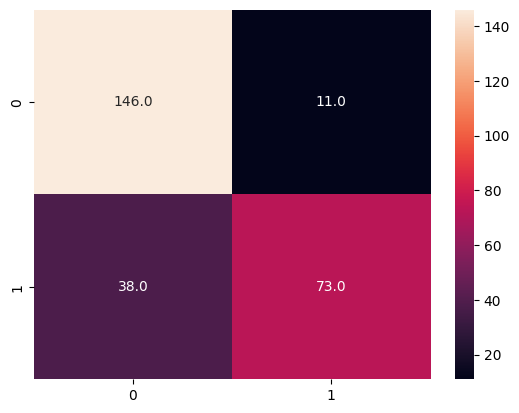

In [17]:
from catboost import CatBoostClassifier

#iterations=50, learning_rate=0.1, depth=3,random_seed=0, verbose=0
#iterations=285, learning_rate=0.11949697012050743, depth=3,random_seed=0, verbose=0

Cat = CatBoostClassifier(iterations=50, 
                         learning_rate=0.1, 
                         depth=3,random_seed=0, 
                         verbose=0)

Cat.fit(x_train, y_train)

pred_cat = Cat.predict(x_val)

print("Accuracy : ",  accuracy_score(y_val, pred_cat))

pred = Cat.predict(test)

# Assuming test_preds contains your predictions
submission = pd.DataFrame({'PassengerId': Id,
                           'Survived': pred})
print(submission)
# Save submission to a CSV file
#submission.to_csv('submission.csv', index=False)

cm = confusion_matrix(y_val, pred_cat)
sb.heatmap(cm,annot = True,fmt = ".1f")
plt.show()

# Logistic regression

In [18]:
clf = LogisticRegression()
clf.fit(x_train, y_train)

pred = clf.predict(x_val)

accuracy_score(y_val, pred)


0.8171641791044776

# Random Forest

accuracy :  0.8022388059701493


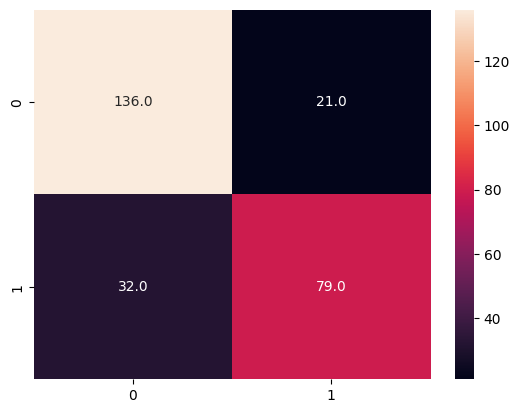

In [19]:
rf = RandomForestClassifier(n_estimators = 100) 

rf.fit(x_train, y_train)

predictions = rf.predict(x_val)

print("accuracy : ",  accuracy_score(y_val, predictions))

cm = confusion_matrix(y_val, predictions)
sb.heatmap(cm,annot = True,fmt = ".1f")
plt.show()

# Arbre de décision

Accuracy :  0.7611940298507462


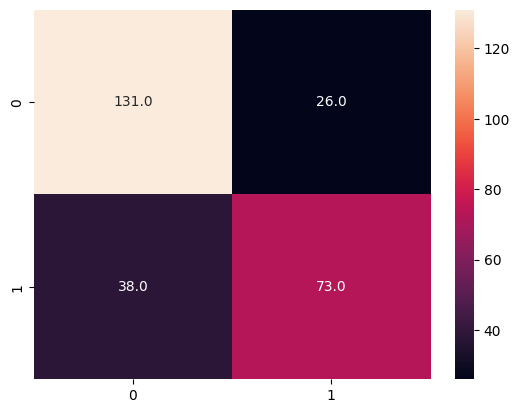

In [20]:
model = DecisionTreeClassifier(criterion = 'entropy')
model.fit(x_train, y_train)

predictions = model.predict(x_val)

print("Accuracy : ",  accuracy_score(y_val, predictions))

cm = confusion_matrix(y_val, predictions)
sb.heatmap(cm,annot = True,fmt = ".1f")
plt.show()

In [21]:
import xgboost as xgb
from xgboost import XGBClassifier

XGB = XGBClassifier()

XGB.fit(x_train, y_train)

predictions_xgb = XGB.predict(x_val)

print("Accuracy : ",  accuracy_score(y_val, predictions_xgb))

Accuracy :  0.7835820895522388


In [22]:
import lightgbm as lgb

# Define model LGBM
LGBM = lgb.LGBMClassifier(verbosity=-1)

# Train model
LGBM.fit(x_train, y_train)

# Make prediction
predictions_lgbm = LGBM.predict(x_val)

# Print accuracy
accuracy_lgbm = accuracy_score(y_val, predictions_lgbm)
print("Accuracy : ", accuracy_lgbm)

Accuracy :  0.7985074626865671


# ----------------------- KNNImputer ----------------------------------------

# We will handle missing value with a new method : replace by KNNImputer
which is a nearest neighbor method to fillna

In [23]:
from sklearn.impute import KNNImputer
IMP = KNNImputer(n_neighbors=1)
encode = LabelEncoder()

def clean_data_nodummy(data, creat_bin):
    """Clean_data function without the fillna.

    Args:
        data (pd.DataFrame): dataset we want to process
        creat_bin (Boolean): if or not we want to create bin for Age and Fare

    Returns:
        data : dataset cleaned
    """

    data['Cabin_Prefix'] = data['Cabin'].apply(lambda x: str(x)[0])  
    data['Ticket_Prefix'] = data['Ticket'].apply(lambda x: x[:1])  
    

    data['Title'] = data['Name'].apply(lambda txt : txt.split()[1].replace('.', ''))
    data['Title'] = data['Title'].apply(lambda txt: txt if txt in ['Mr', 'Miss', 'Mrs', 'Master'] else 'unk')
    
        
    if creat_bin:
        data['Age_Range'] = pd.cut(data['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])
        data['Fare_Range'] = pd.cut(data['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])
        
        data = data.drop(['PassengerId', 'Name', 'Age', 'Ticket', 'Fare', 'Cabin'], axis = 1)
    else:
        data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
    
    return data

need labelize :  Sex
need labelize :  Embarked
need labelize :  Cabin_Prefix
need labelize :  Ticket_Prefix
need labelize :  Title
need labelize :  Age_Range
need labelize :  Fare_Range


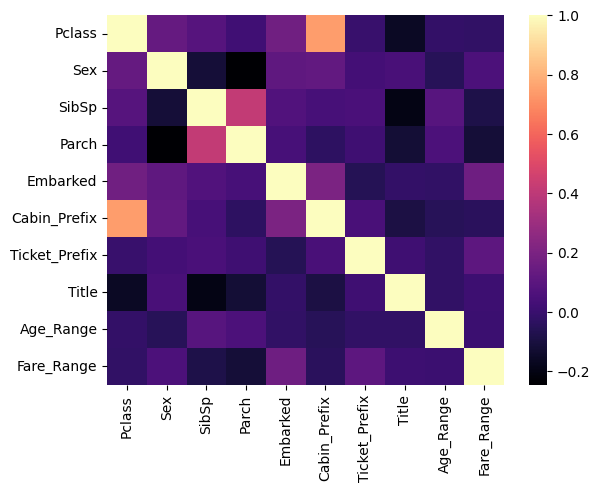

(891, 10) (623,)


In [24]:
# We will use utilities.pre_knnimput which will process dataset and apply KNNImputer

train = pd.read_csv('/kaggle/input/titanic-dataset/train.csv')
test = pd.read_csv('/kaggle/input/titanic-dataset/test.csv')

Id = test.PassengerId
Survived = train.Survived
train = train.drop(['Survived'], axis=1)

train, test = clean_data_nodummy(train, creat_bin=True), clean_data_nodummy(test, creat_bin=True)

# Use KKNImputer for missing values

train_imputed, test_imputed = utilities.pre_knnimput(train, test)

correlation = train_imputed.corr()
sb.heatmap(correlation, cmap = 'magma')
plt.show()

print(train_imputed.shape, y_train.shape)


# Split and train

In [25]:
# We split

x_train, x_val, label_train, label_val = train_test_split(train_imputed, Survived, test_size = 0.3, random_state = 42)
print("len x_train: ",x_train.shape)
print("len x_val: ", x_val.shape)
print("len label_train: ",label_train.shape)
print("len label_val: ", label_val.shape)


len x_train:  (623, 10)
len x_val:  (268, 10)
len label_train:  (623,)
len label_val:  (268,)


# Regression

0.7947761194029851


<Axes: >

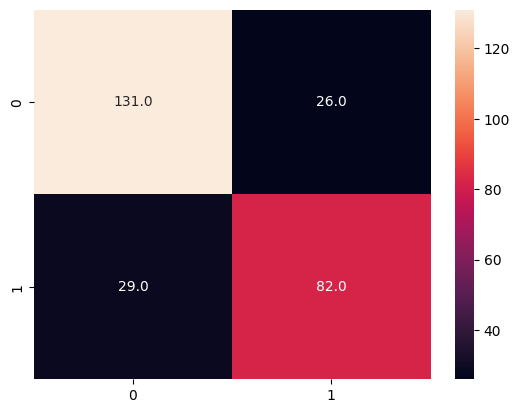

In [26]:
clf = LogisticRegression()
clf.fit(x_train, label_train)

pred = clf.predict(x_val)

print(accuracy_score(label_val, pred))

sb.heatmap(confusion_matrix(label_val, pred), annot = True,fmt = ".1f")

# Random forest

Accuracy :  0.8059701492537313


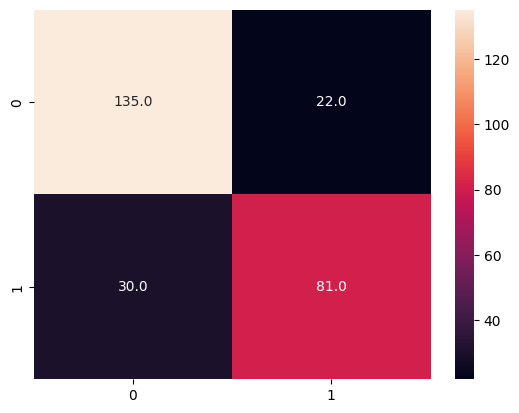

In [27]:
model1 = RandomForestClassifier(n_estimators = 100) 

model1.fit(x_train, label_train)

predictions = model1.predict(x_val)

print("Accuracy : ",  accuracy_score(y_val, predictions))

cm = confusion_matrix(label_val, predictions)
sb.heatmap(cm,annot = True,fmt = ".1f")
plt.show()

# Decision Tree

Accuracy :  0.75


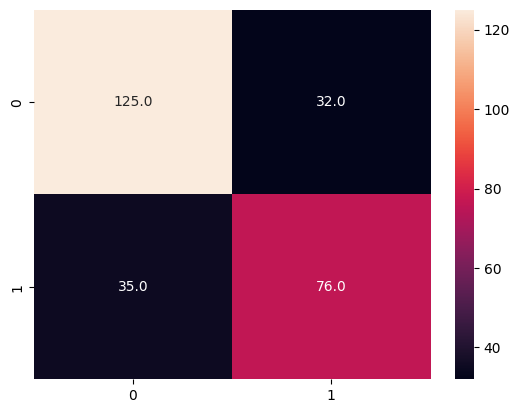

In [28]:
model = DecisionTreeClassifier(criterion = 'entropy')
model.fit(x_train, label_train)

predictions = model.predict(x_val)

print("Accuracy : ",  accuracy_score(label_val, predictions))

cm = confusion_matrix(label_val, predictions)
sb.heatmap(cm,annot = True,fmt = ".1f")
plt.show()

In [29]:
import xgboost as xgb
from xgboost import XGBClassifier

XGB = XGBClassifier()

XGB.fit(x_train, label_train)

predictions_xgb = XGB.predict(x_val)

print("Accuracy : ",  accuracy_score(label_val, predictions_xgb))

Accuracy :  0.8059701492537313


In [30]:
from catboost import CatBoostClassifier

Cat = CatBoostClassifier(iterations=3000,
                        learning_rate=0.1,
                        depth=3,random_seed=0, verbose=0)

Cat.fit(x_train, label_train)

pred_cat = Cat.predict(x_val)

print("Accuracy : ",  accuracy_score(label_val, pred_cat))

Accuracy :  0.7873134328358209
